# Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
import time
import json
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.stats import norm
from xskillscore import crps_quadrature, crps_ensemble

import sys
sys.path.append('/'.join(sys.path[0].split('/')[:-1]))
from modules.architectures import *

from modules.swag import data, models, utils, losses
from modules.swag.posteriors import SWAG

import modules.architectures as modelArchitectures
from modules.full_pipeline import compute_errors, _inner
from modules.plotting import plot_intervalmap, plot_signal
from modules.data import hp_to_equiangular
from modules.test import compute_rmse_healpix, compute_R2

# Utility functions

In [3]:
def to_equi(data):
    data_equi = []
    for i in range(len(obs_2w.time.values)):
        data_inter = hp_to_equiangular(data.isel(time=i), resolution)
        data_inter = data_inter.sel(lat=lats, lon=lons)
        data_equi.append(data_inter)
    data_equi = xr.concat(data_equi, dim="time")
    data_equi['time'] = data.time.values
    
    return data_equi

In [4]:
def to_equi_lead_times(data):
    data_equi = []
    for i in range(len(data.lead_time.values)):
        data_inter = hp_to_equiangular(data.isel(lead_time=i), resolution)
        data_inter = data_inter.sel(lat=lats, lon=lons)
        data_equi.append(data_inter)
    data_equi = xr.concat(data_equi, dim="lead_time")
    data_equi['lead_time'] = data.lead_time.values
    
    return data_equi

In [5]:
def to_equi_times(data):
    data_equi = []
    for time in data.time.values:
        data_time = []
        for lead_time in data.lead_time.values:
            data_inter = hp_to_equiangular(data.sel(lead_time=lead_time, time=time), resolution)
            data_inter = data_inter.sel(lat=lats, lon=lons)
            data_time.append(data_inter)
        data_time = xr.concat(data_time, dim="lead_time")
        data_time['lead_time'] = data.lead_time.values
        data_equi.append(data_time)
    data_equi = xr.concat(data_equi, dim="time")
    data_equi['time'] = data.time.values
    
    return data_equi

# Daily cycle examinations in 8 random locations

In [6]:
description_epoch = 'all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch'
figures_path = '../data/healpix/figures/' + description_epoch + '/'

config_file = 'config_s01_two_steps_small.json'

with open("../configs/" + config_file) as json_data_file:
        cfg = json.load(json_data_file)

# Define paths
datadir = cfg['directories']['datadir']
input_dir = datadir + cfg['directories']['input_dir']
model_save_path = datadir + cfg['directories']['model_save_path']
pred_save_path = datadir + cfg['directories']['pred_save_path']
metrics_path = datadir + cfg['directories']['metrics_path']

resolution = cfg['model_parameters']['resolution']
max_lead_time = cfg['training_constants']['max_lead_time']

lead_time = 6
lead_times = np.arange(lead_time, max_lead_time+lead_time, lead_time)

In [7]:
obs_equi = xr.open_dataset(pred_save_path + 'observations_equi.nc')

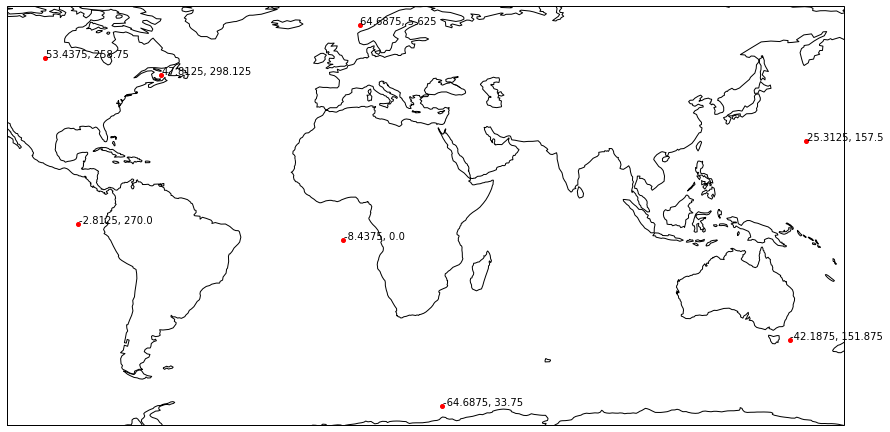

In [8]:
random.seed(1)
lats = random.choices(obs_equi.lat.values, k=8)
lons = random.choices(obs_equi.lon.values, k=8)

proj = ccrs.PlateCarree()
f, ax = plt.subplots(figsize=(15,15), subplot_kw=dict(projection=proj))
for lat, lon in zip(lats, lons):
    ax.plot(lon, lat,  markersize=4, marker='o', color='red', transform=proj)
    ax.text(lon+0.3, lat+0.3, f"{lat}, {lon}", transform=proj)
ax.coastlines()
plt.show()

In [9]:
# Load SWAG realizations for given scale
realizations_2w = []
scale = "03"
for i in range(10):
    filename_realization = f'all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_swag_freq10_epoch11_swag_scale{scale}_realization{i+1}.nc'
    realization = xr.open_dataset(pred_save_path+filename_realization).chunk('auto')
    realization = realization.drop('lon').drop('lat').isel(lead_time=0, time=slice(0,4*24)).load()
    realizations_2w.append(realization)

# SWA model
filename_swa = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_swag_freq10_epoch11_swag_scale00.nc"
swa_2w = xr.open_dataset(pred_save_path+filename_swa).chunk('auto')

# Classic training
filename_classic = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_epoch11.nc"
classic_2w = xr.open_dataset(pred_save_path+filename_classic).chunk('auto')

# Load observations
obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')

common_time = list(set(classic_2w.time.values).intersection(obs.time.values))
common_time.sort()

common_lead_time = list(set(classic_2w.lead_time.values).intersection(obs.lead_time.values))
common_lead_time.sort()
obs = obs.sel(dict(time=common_time, lead_time=common_lead_time))

In [10]:
swa_2w = swa_2w.drop('lon').drop('lat').isel(lead_time=0, time=slice(0,4*24)).load()
classic_2w = classic_2w.drop('lon').drop('lat').isel(lead_time=0, time=slice(0,4*24)).load()
obs_2w = obs.isel(lead_time=0, time=slice(0,4*24)).load()

In [11]:
realizations_2w_equi = [to_equi(realization) for realization in realizations_2w]
swa_2w_equi = to_equi(swa_2w)
classic_2w_equi = to_equi(classic_2w)
obs_2w_equi = to_equi(obs_2w)

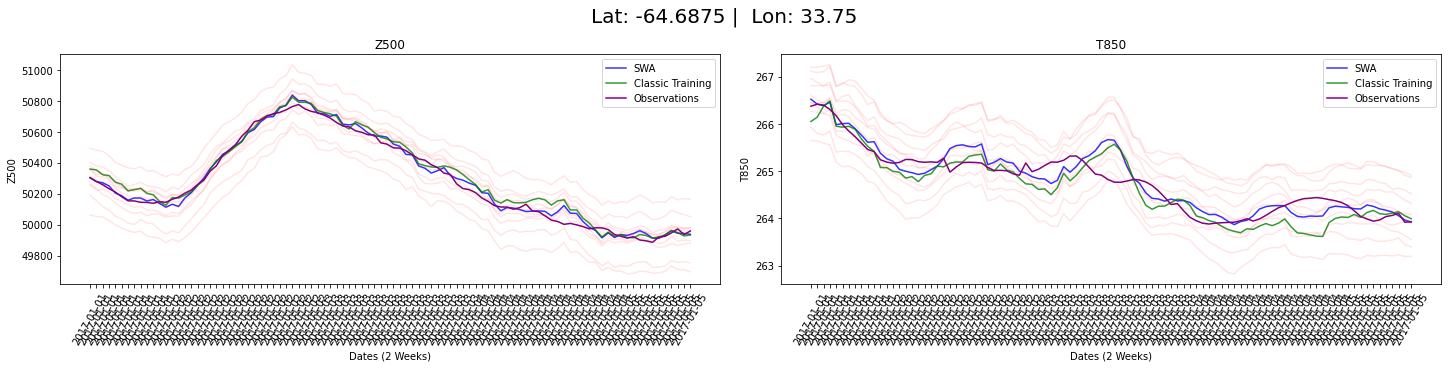

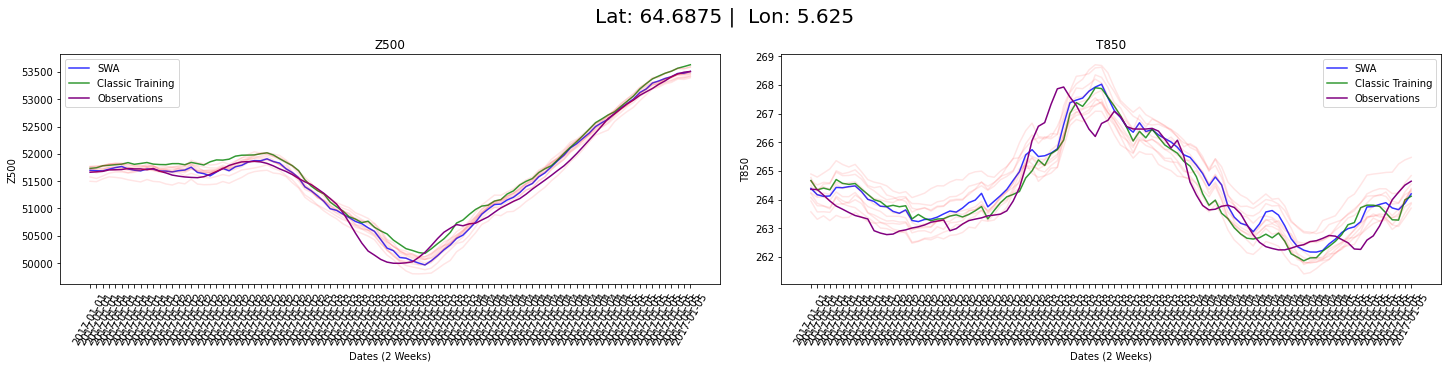

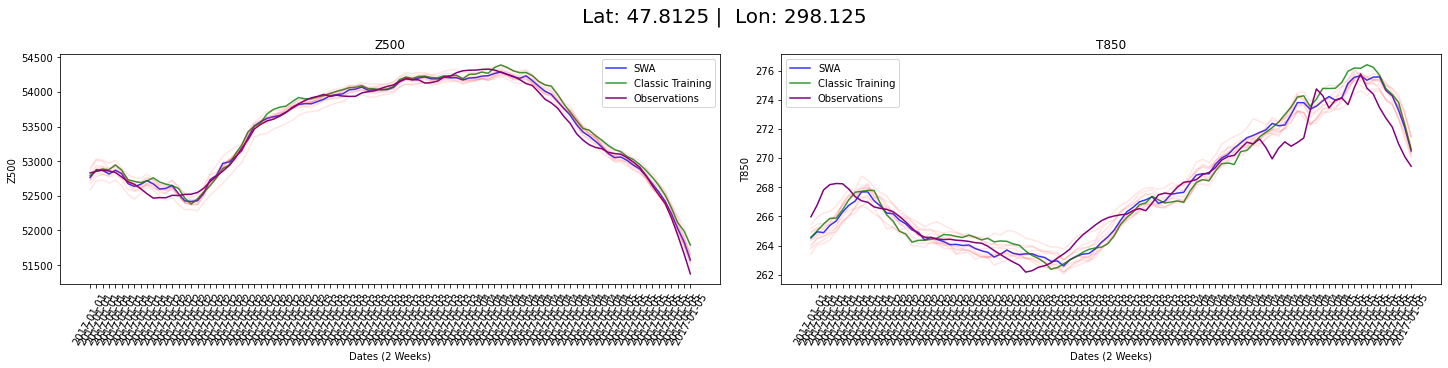

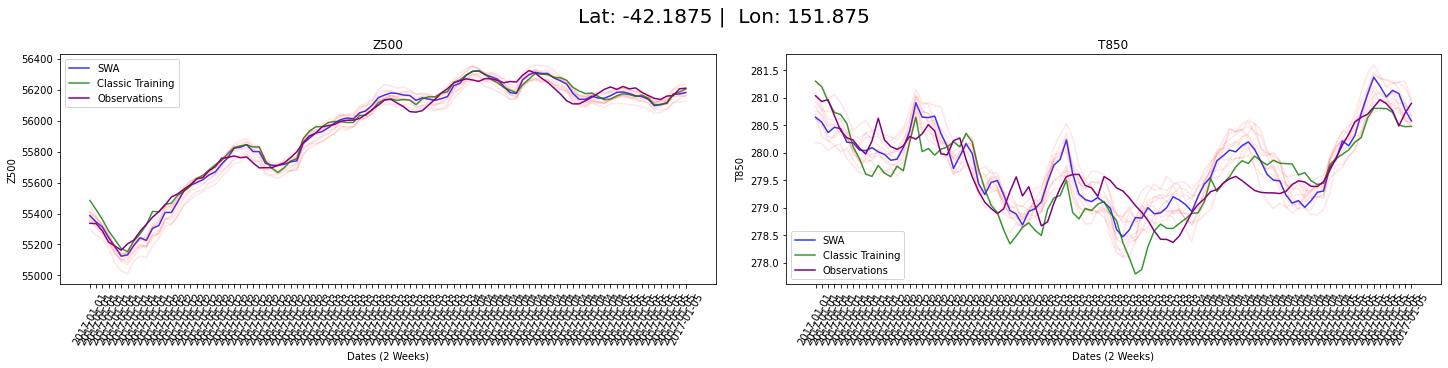

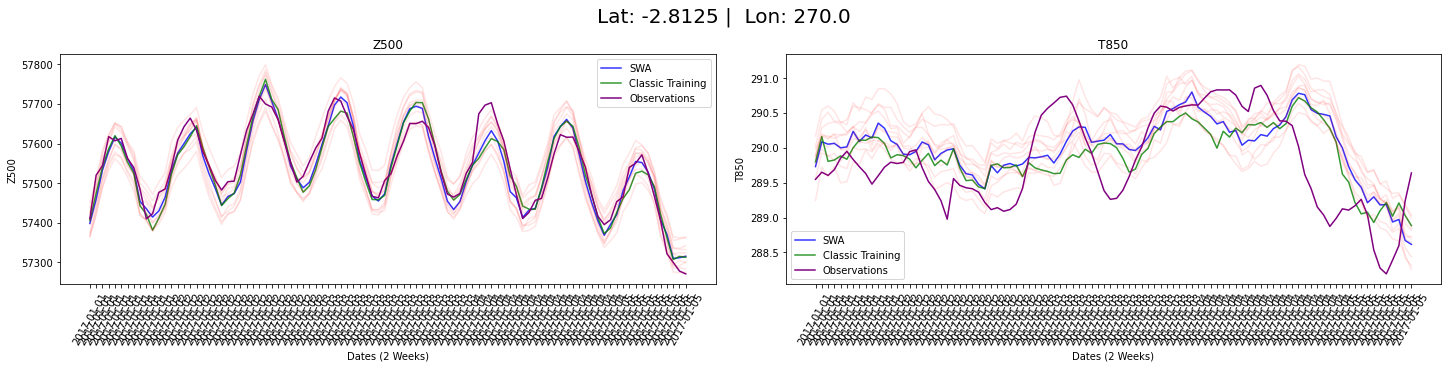

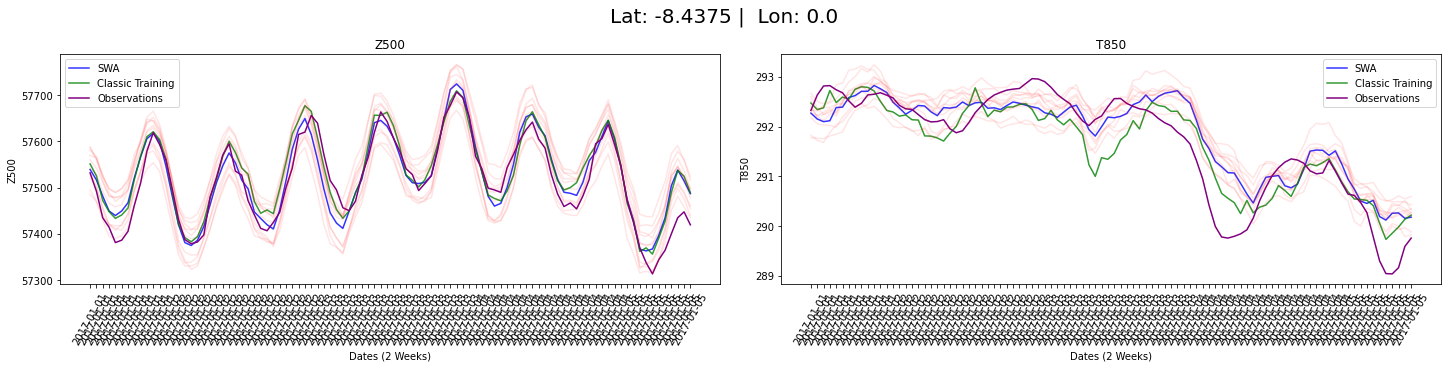

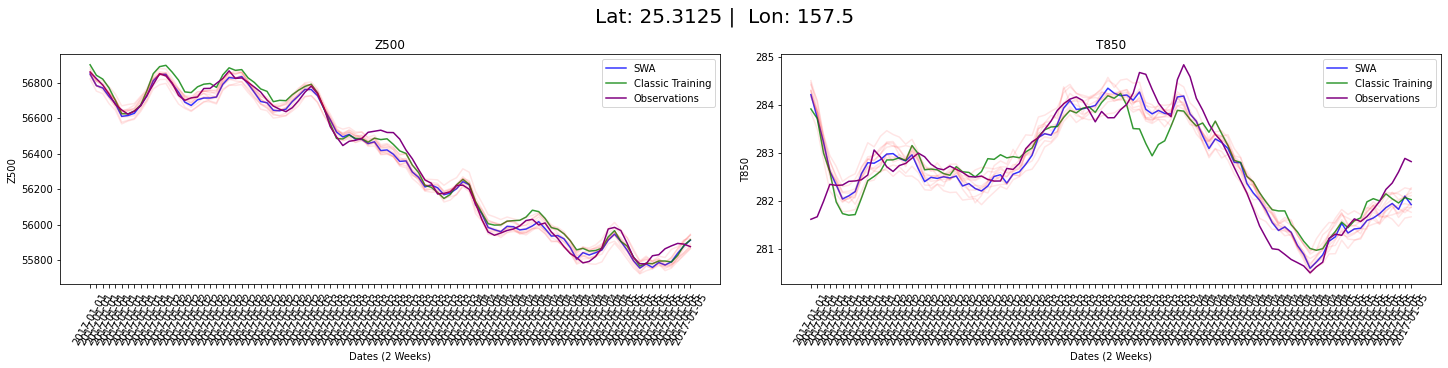

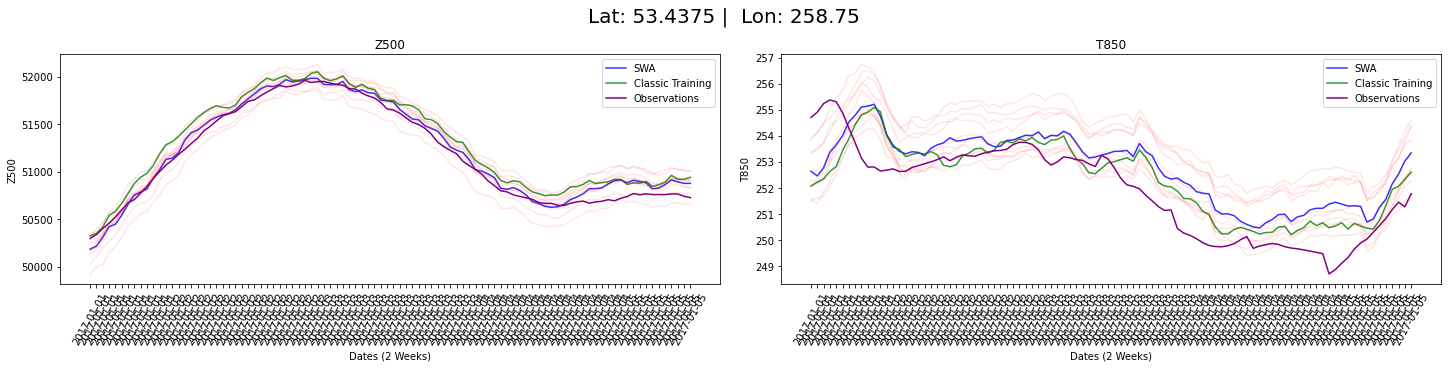

In [12]:
times = swa_2w_equi.time.values

for lat, lon in zip(lats, lons):
    # print("Lat:", lat, " | Lon:", lon)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), constrained_layout=True)
    
    realizations_to_plot = [r.sel(lat=lat, lon=lon) for r in realizations_2w_equi]
    swa_to_plot = swa_2w_equi.sel(lat=lat, lon=lon)
    classic_to_plot = classic_2w_equi.sel(lat=lat, lon=lon)
    obs_to_plot = obs_2w_equi.sel(lat=lat, lon=lon)
    
    ax1.plot(times, swa_to_plot.z.values, color='blue', alpha=0.8, label='SWA')
    ax1.plot(times, classic_to_plot.z.values, color='green', alpha=0.8, label='Classic Training')
    ax1.plot(times, obs_to_plot.z.values, color='purple', label='Observations')

    for i, r in enumerate(realizations_to_plot):
        ax1.plot(times, r.z.values, color='red', alpha=0.1)

    ax2.plot(times, swa_to_plot.t.values, color='blue', alpha=0.8, label='SWA')
    ax2.plot(times, classic_to_plot.t.values, color='green', alpha=0.8, label='Classic Training')
    ax2.plot(times, obs_to_plot.t.values, color='purple', label='Observations')

    for i, r in enumerate(realizations_to_plot):
        ax2.plot(times, r.t.values, color='red', alpha=0.1)
        

    ax1.set_xlabel('Dates (2 Weeks)')
    ax1.set_xticks(times)
    ax1.xaxis.set_tick_params(rotation=60)
    ax2.set_xticks(times)
    ax2.set_xlabel('Dates (2 Weeks)')
    ax2.xaxis.set_tick_params(rotation=60)
    
    ax1.set_ylabel('Z500')
    ax2.set_ylabel('T850')

    ax1.set_title('Z500')
    ax2.set_title('T850')

    ax1.legend()
    ax2.legend()

    f.suptitle(f"Lat: {lat} |  Lon: {lon}", fontsize=20, horizontalalignment='center')

    plt.show()

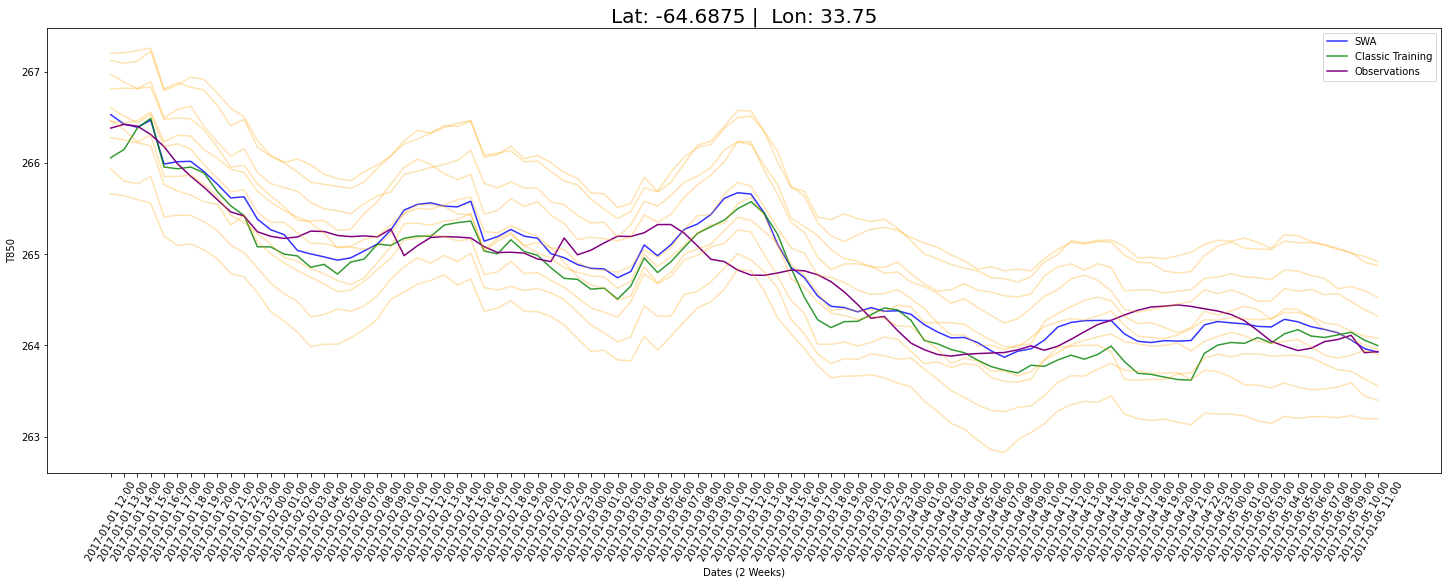

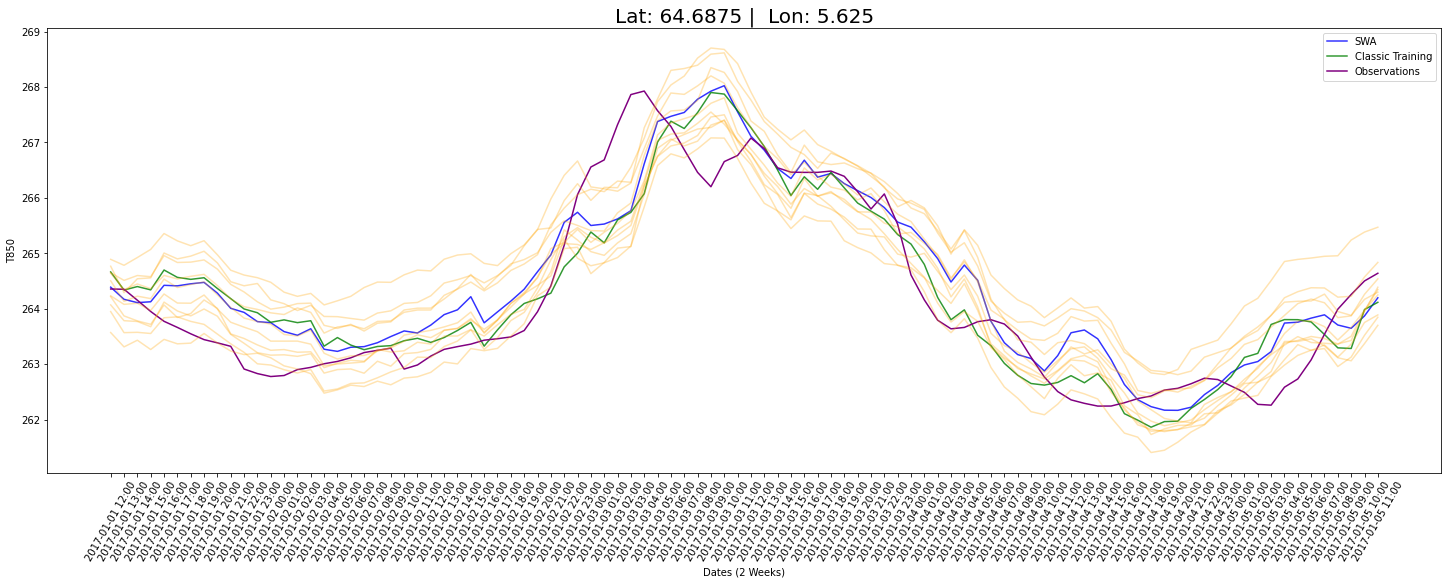

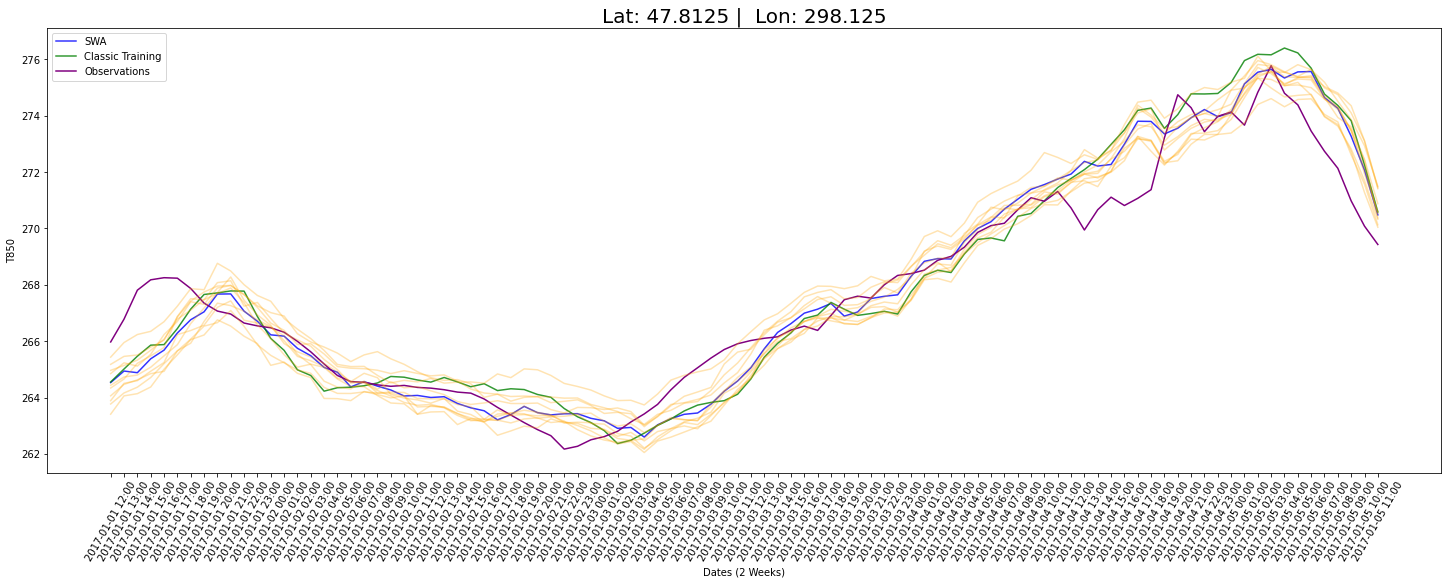

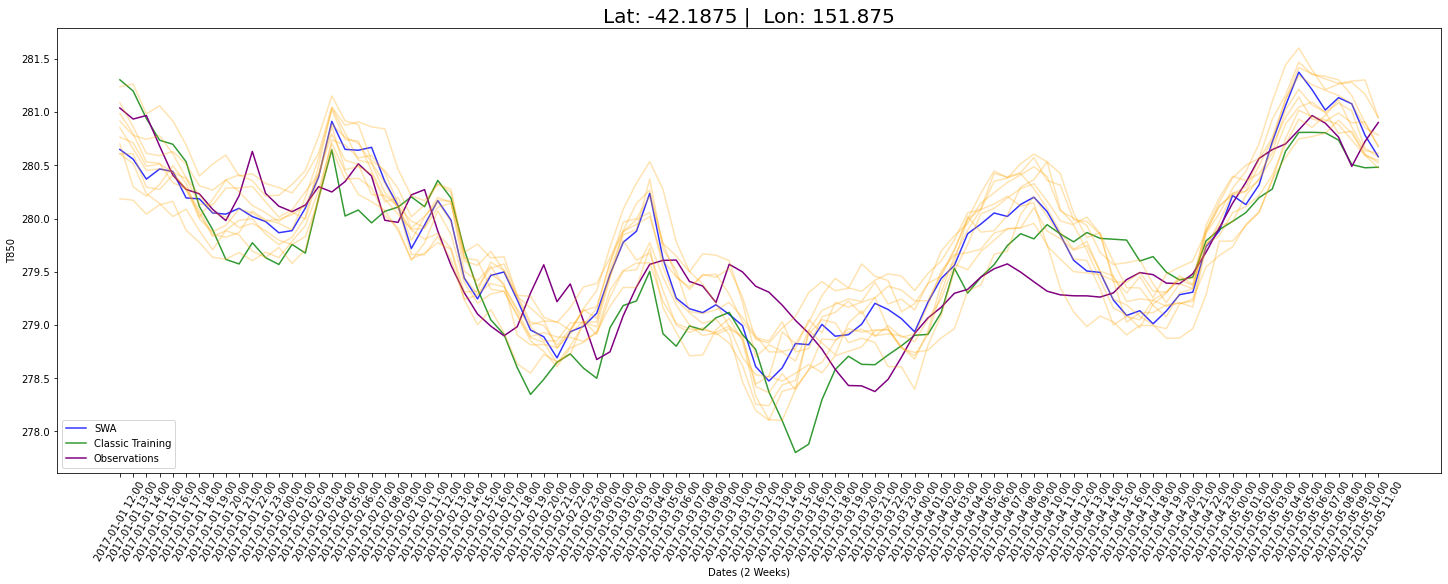

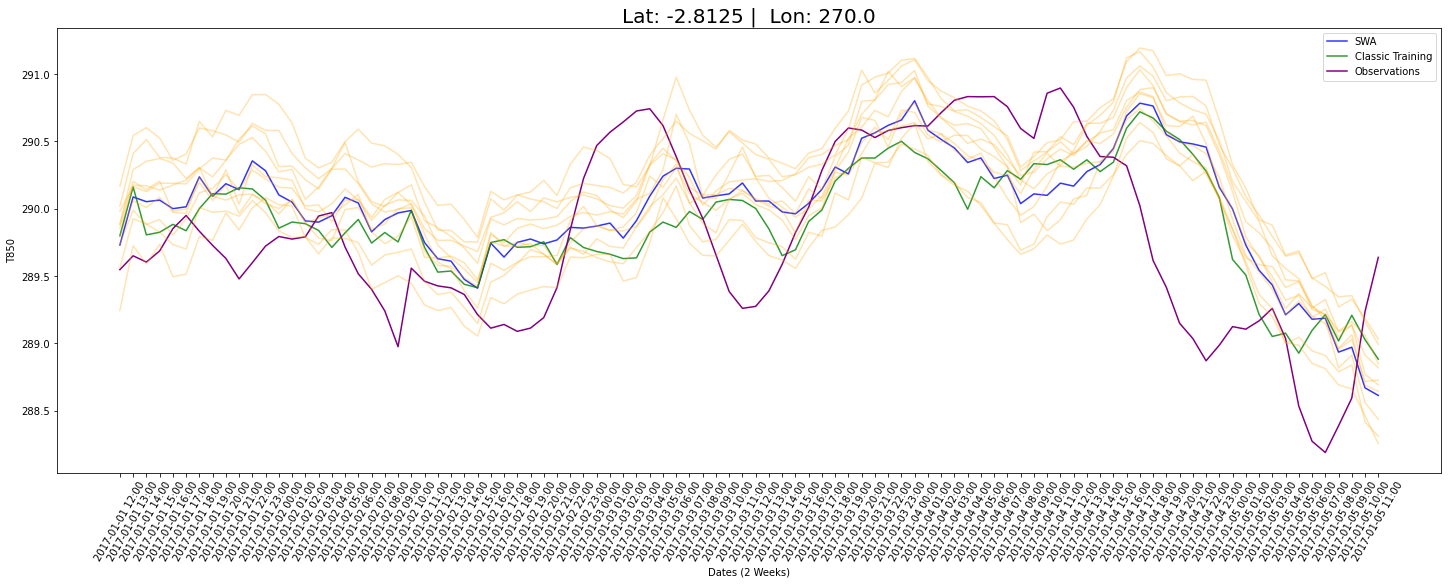

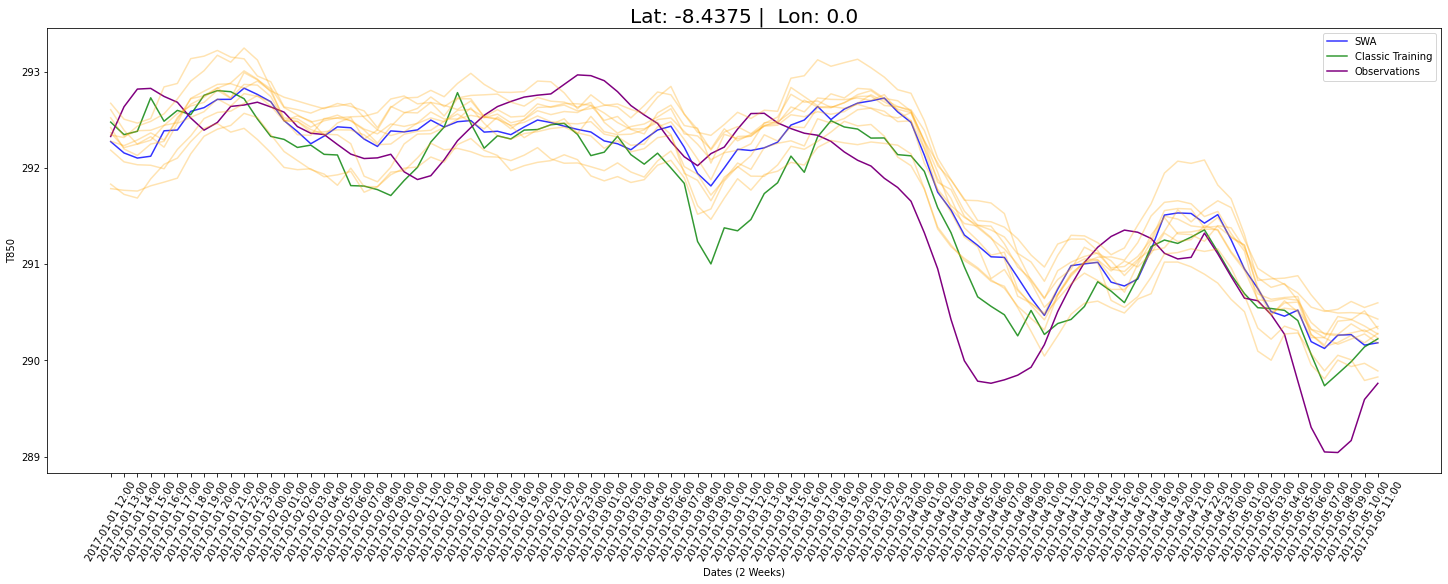

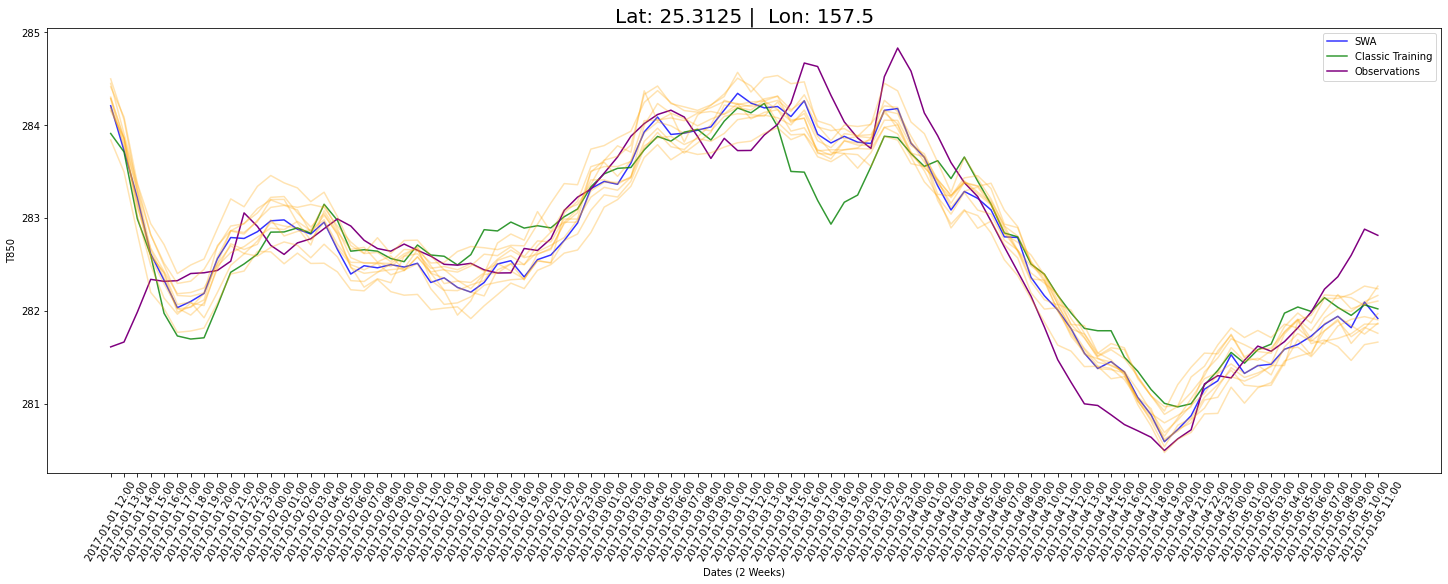

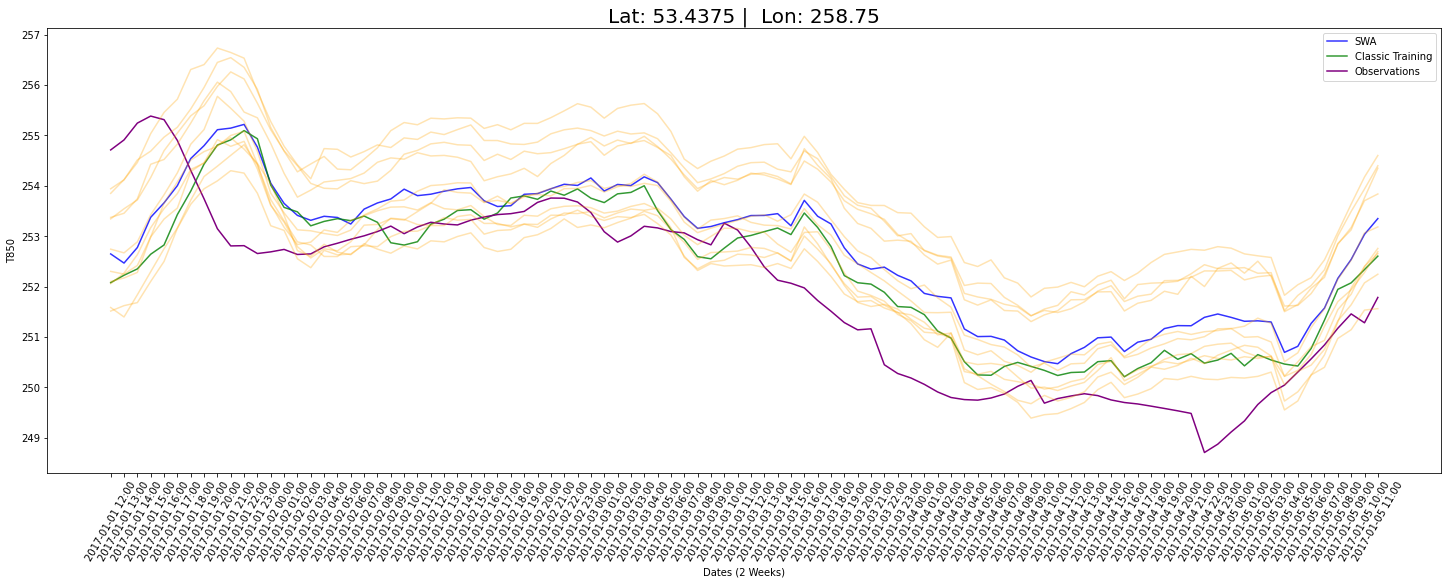

In [13]:
times = swa_2w_equi.time.values

for lat, lon in zip(lats, lons):
    # print("Lat:", lat, " | Lon:", lon)
    f, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
    
    realizations_to_plot = [r.sel(lat=lat, lon=lon, time=times) for r in realizations_2w_equi]
    swa_to_plot = swa_2w_equi.sel(lat=lat, lon=lon, time=times)
    classic_to_plot = classic_2w_equi.sel(lat=lat, lon=lon, time=times)
    obs_to_plot = obs_2w_equi.sel(lat=lat, lon=lon, time=times)

    ax.plot(times, swa_to_plot.t.values, color='blue', alpha=0.8, label='SWA')
    ax.plot(times, classic_to_plot.t.values, color='green', alpha=0.8, label='Classic Training')
    ax.plot(times, obs_to_plot.t.values, color='purple', label='Observations')

    for i, r in enumerate(realizations_to_plot):
        plt.plot(times, r.t.values, color='orange', alpha=0.3)
        
    ax.set_xticks(times)
    ax.set_xlabel('Dates (2 Weeks)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    ax.xaxis.set_tick_params(rotation=60) 
    ax.set_ylabel('T850')

    ax.legend()

    plt.title(f"Lat: {lat} |  Lon: {lon}", fontsize=20, horizontalalignment='center')

    plt.show()

# Fix the date and check evolution over lead times for the same locations

In [15]:
# SWAG realizations with given scale
time = 5
realizations = []
scale = "03"
for i in range(10):
    filename_realization = f'all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_swag_freq10_epoch11_swag_scale{scale}_realization{i+1}.nc'
    realization = xr.open_dataset(pred_save_path+filename_realization).chunk('auto')
    realization = realization.drop('lon').drop('lat').isel(time=time).load()
    realizations.append(realization)

# Load observations
obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')

# SWA
filename_swa = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_swag_freq10_epoch11_swag_scale00.nc"
swa = xr.open_dataset(pred_save_path+filename_swa).chunk('auto')


# Classic training
filename_classic = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_epoch11.nc"
classic = xr.open_dataset(pred_save_path+filename_classic).chunk('auto')


common_time = list(set(classic.time.values).intersection(obs.time.values))
common_time.sort()

common_lead_time = list(set(classic.lead_time.values).intersection(obs.lead_time.values))
common_lead_time.sort()
obs = obs.sel(dict(time=common_time, lead_time=common_lead_time))

In [16]:
obs = obs.isel(time=time).load()
swa = swa.drop('lon').drop('lat').isel(time=time).load()
classic = classic.drop('lon').drop('lat').isel(time=time).load()

In [17]:
# Equiangular 
realizations_equi = [to_equi_lead_times(realization) for realization in realizations]
swa_equi = to_equi_lead_times(swa)
classic_equi = to_equi_lead_times(classic)
obs_equi = to_equi_lead_times(obs)

In [18]:
shifted_obs = obs_equi.shift(lead_time=1)
shifted_obs_2 = obs_equi.shift(lead_time=2)

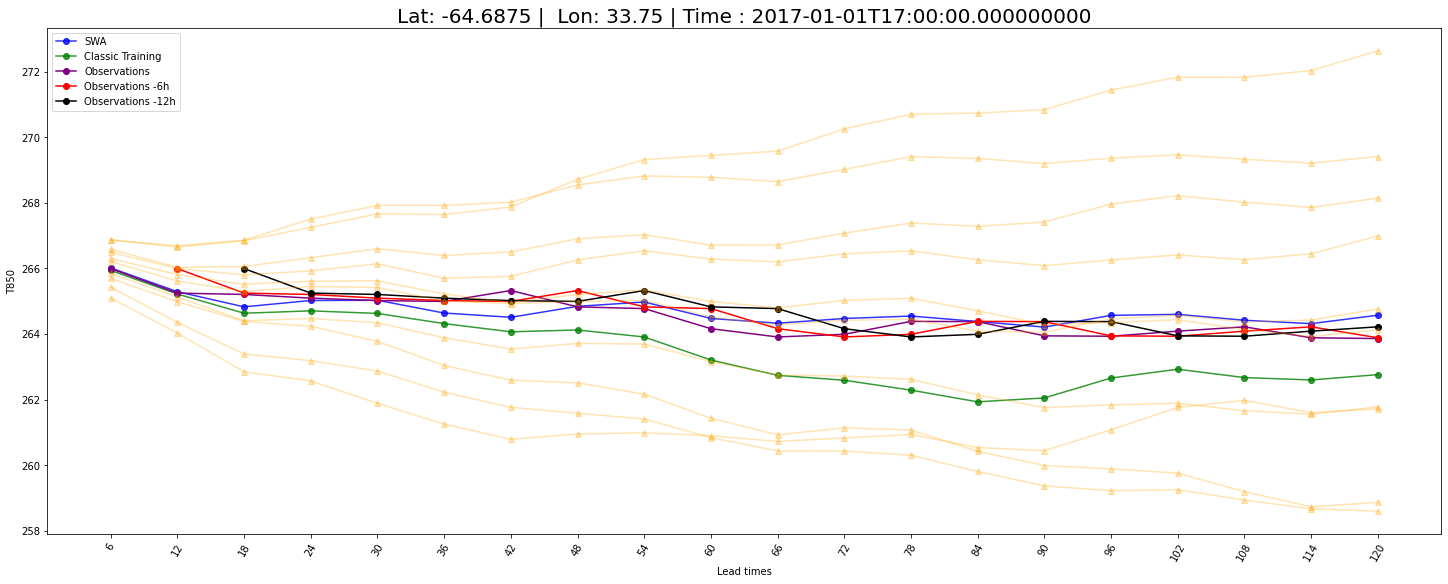

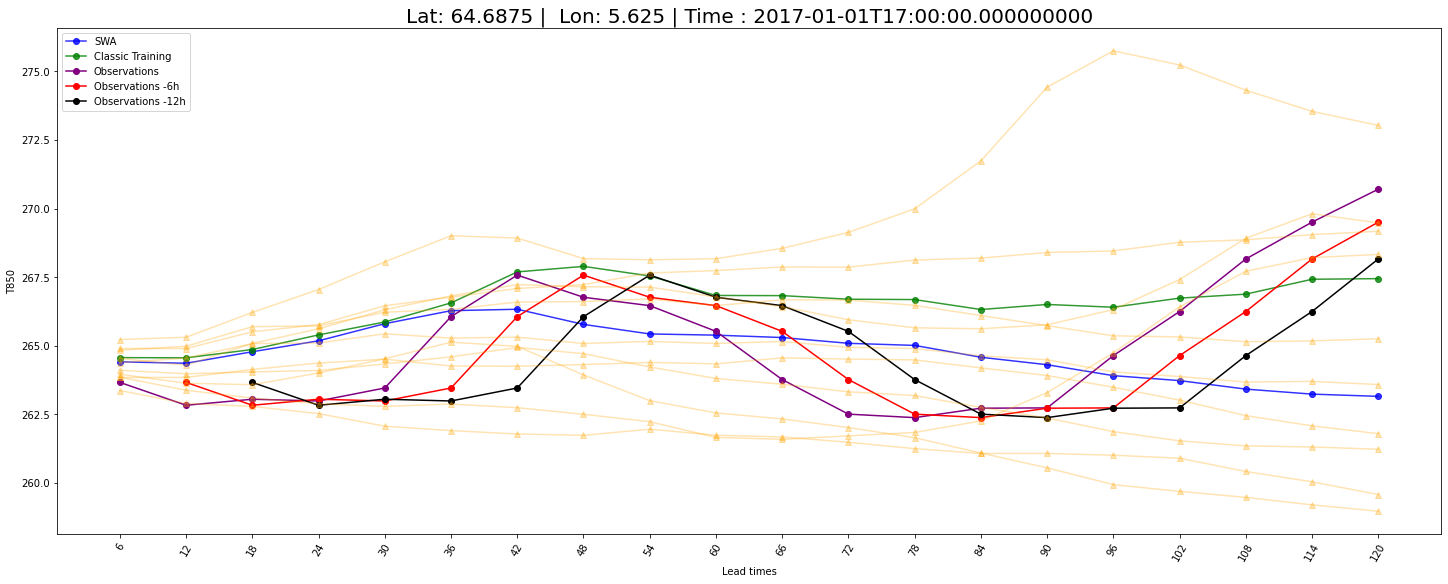

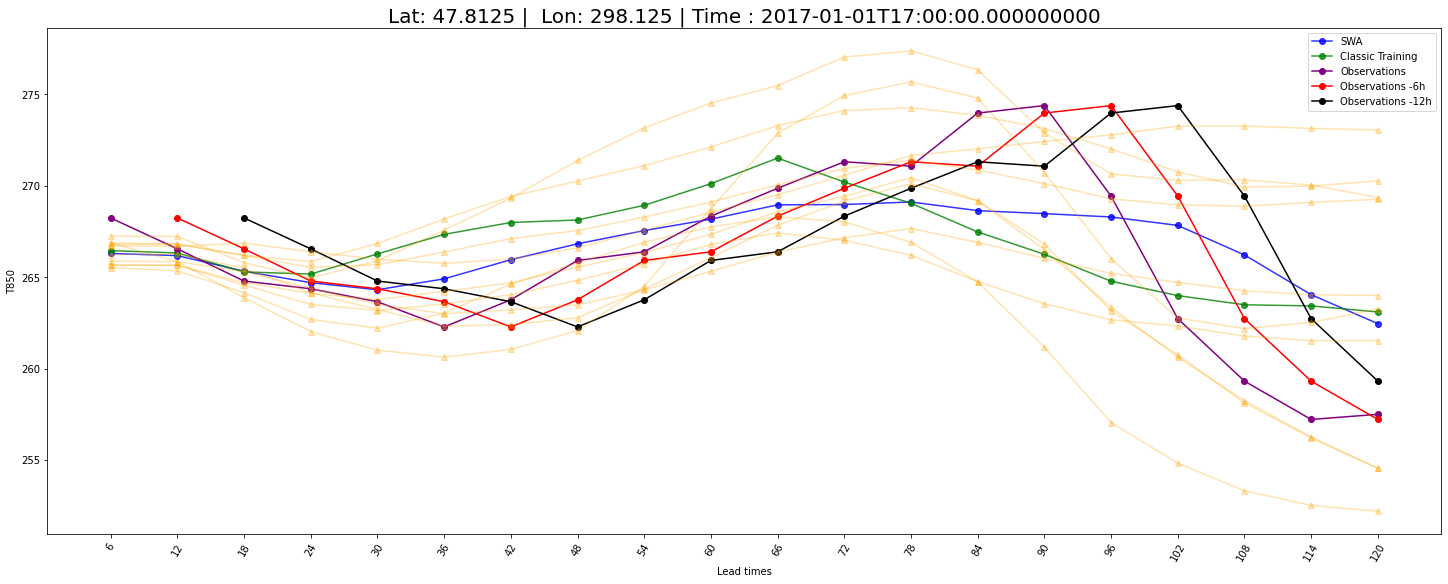

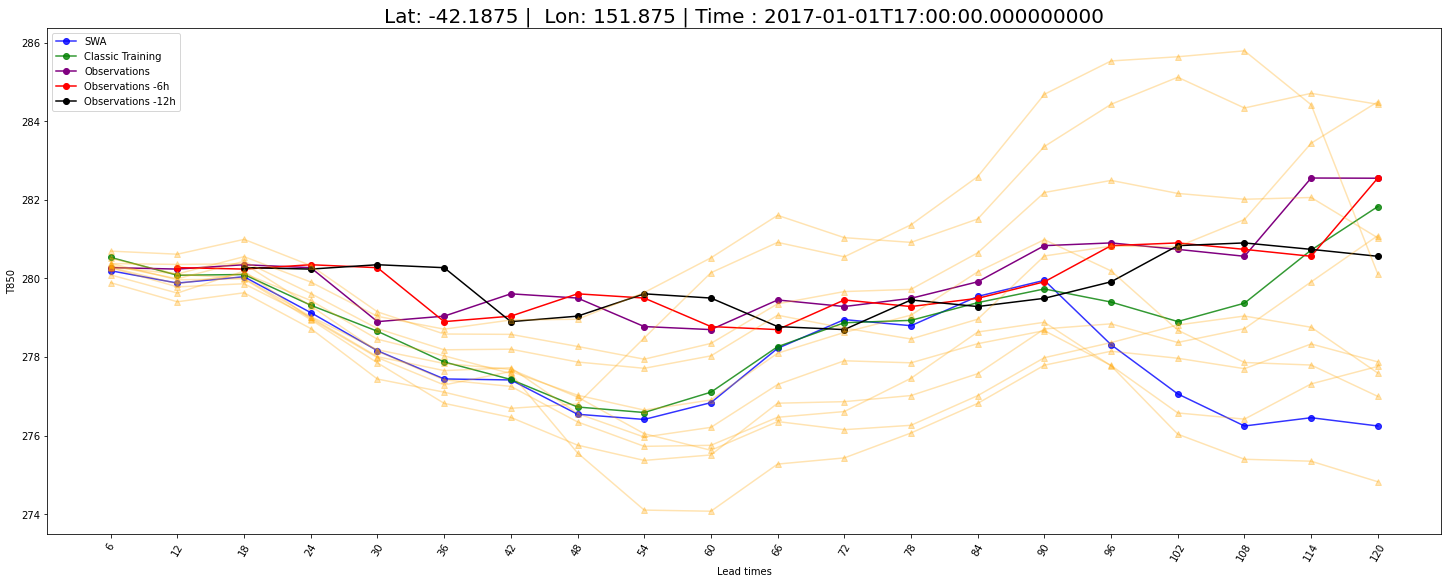

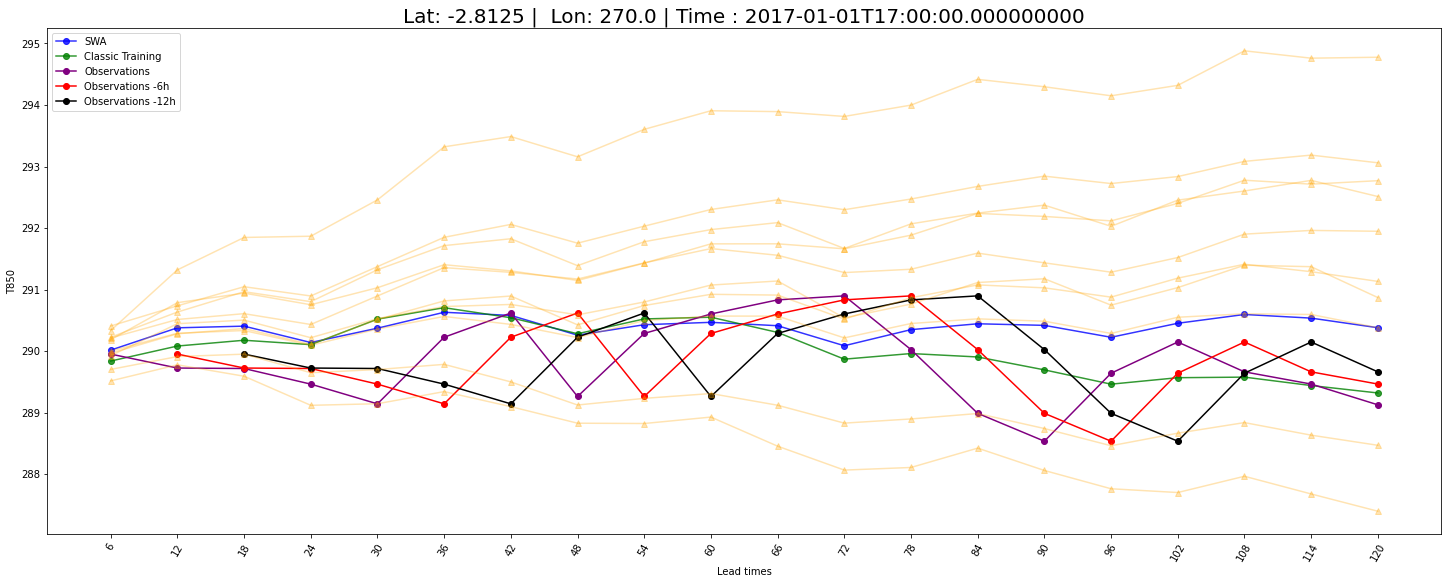

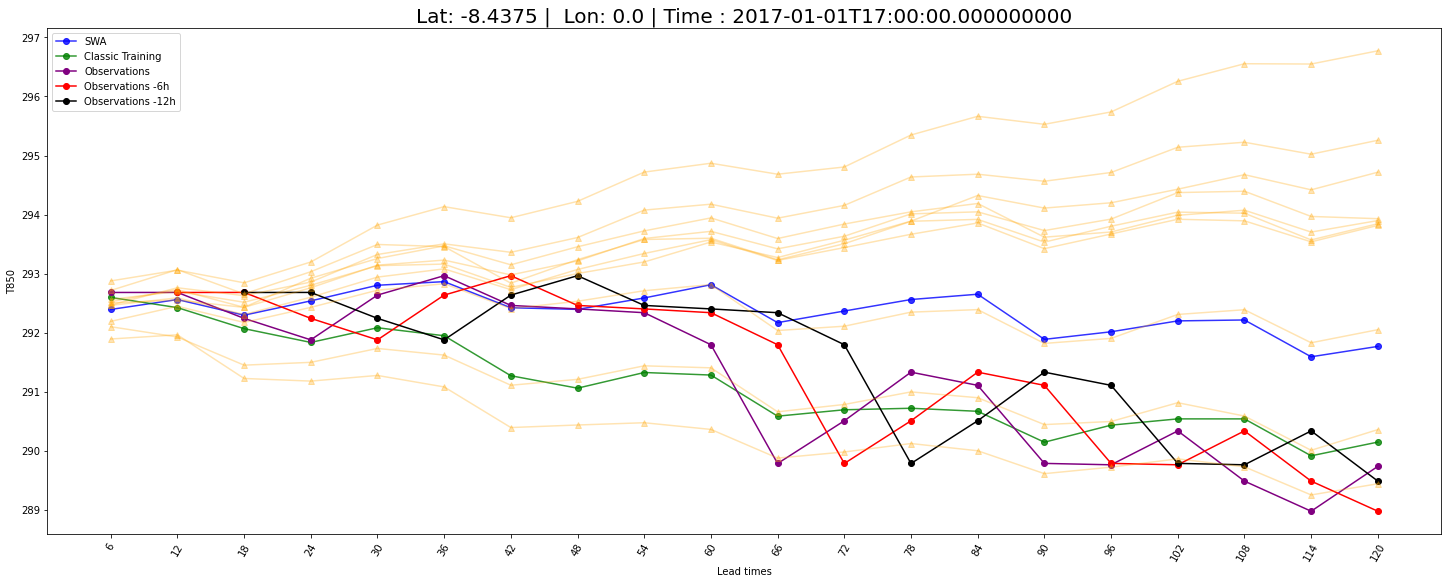

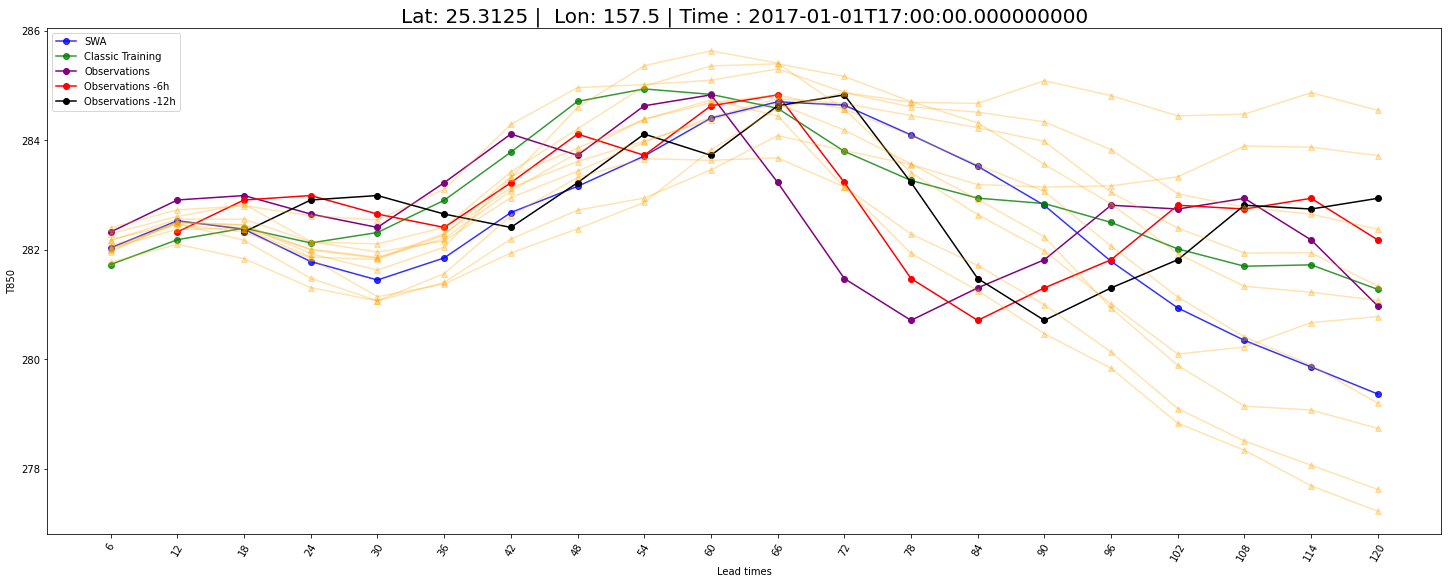

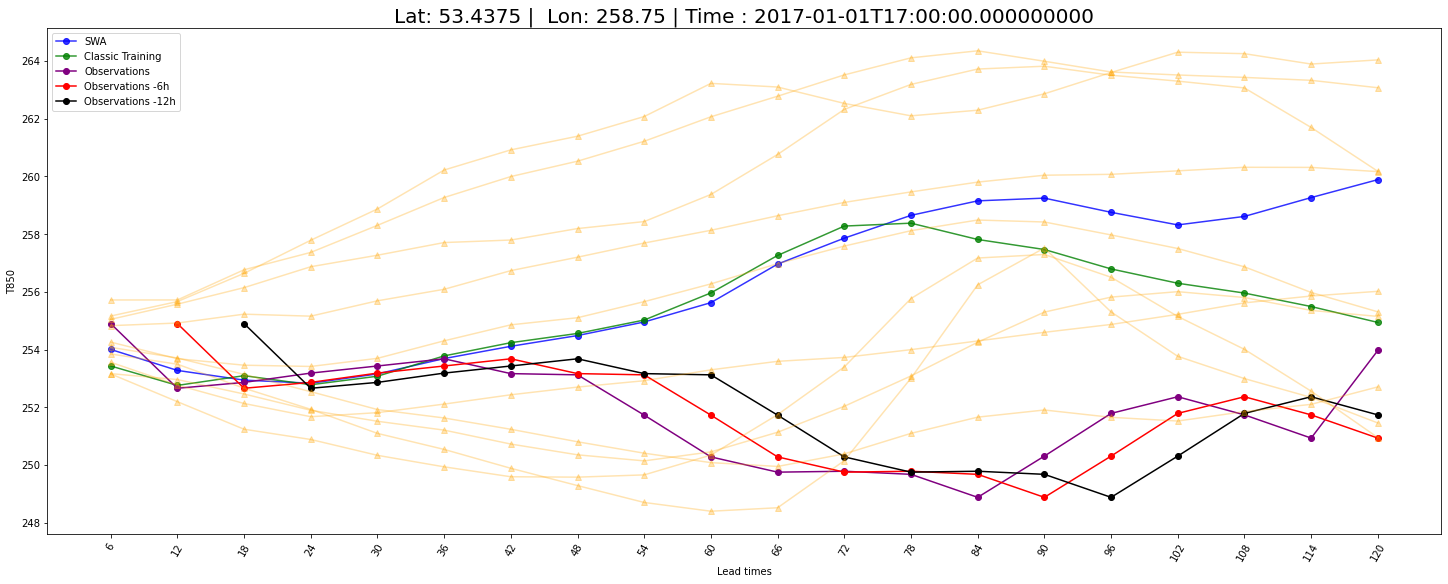

In [22]:
times = swa_equi.lead_time.values

for lat, lon in zip(lats, lons):
    # print("Lat:", lat, " | Lon:", lon)
    f, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
    
    realizations_to_plot = [r.sel(lat=lat, lon=lon, lead_time=times) for r in realizations_equi]
    swa_to_plot = swa_equi.sel(lat=lat, lon=lon, lead_time=times)
    classic_to_plot = classic_equi.sel(lat=lat, lon=lon, lead_time=times)
    obs_to_plot = obs_equi.sel(lat=lat, lon=lon, lead_time=times)
    shifted_obs_to_plot = shifted_obs.sel(lat=lat, lon=lon, lead_time=times)
    shifted_obs_2_to_plot = shifted_obs_2.sel(lat=lat, lon=lon, lead_time=times)

    ax.plot(times, swa_to_plot.t.values, color='blue', alpha=0.8, marker='o', label='SWA')
    ax.plot(times, classic_to_plot.t.values, color='green', alpha=0.8, marker='o', label='Classic Training')
    ax.plot(times, obs_to_plot.t.values, color='purple', marker='o', label='Observations')
    ax.plot(times, shifted_obs_to_plot.t.values, color='red', marker='o', label='Observations -6h')
    ax.plot(times, shifted_obs_2_to_plot.t.values, color='black', marker='o', label='Observations -12h')
    
    for i, r in enumerate(realizations_to_plot):
        ax.plot(times, r.t.values, color='orange', marker='^', alpha=0.3)
        
    ax.set_xticks(times)
    ax.set_xlabel('Lead times')
    ax.xaxis.set_tick_params(rotation=60) 
    ax.set_ylabel('T850')

    ax.legend()

    plt.title(f"Lat: {lat} |  Lon: {lon} | Time : {obs.time.values}", fontsize=20, 
              horizontalalignment='center')

    plt.show()

# Let's examine the tropics

In [23]:
# SWAG realizations with given scale
time = [np.datetime64('2017-01-02T17:00:00.000000000'), np.datetime64('2017-01-02T20:00:00.000000000'), 
        np.datetime64('2017-01-02T23:00:00.000000000'), np.datetime64('2017-01-03T02:00:00.000000000')]
pixel = (-2.8125, 270.0)
realizations_tropics = []
scale = "03"
for i in range(10):
    filename_realization = f'all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_swag_freq10_epoch11_swag_scale{scale}_realization{i+1}.nc'
    realization = xr.open_dataset(pred_save_path+filename_realization).chunk('auto')
    realization = realization.drop('lon').drop('lat').sel(time=time).load()
    realizations_tropics.append(realization)

# Load observations
obs = xr.open_mfdataset(pred_save_path + 'observations_nearest.nc', combine='by_coords')

# SWA
filename_swa = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_swag_freq10_epoch11_swag_scale00.nc"
swa_tropics = xr.open_dataset(pred_save_path+filename_swa).chunk('auto')

# Classic training
filename_classic = "all_const_len2_delta_6_architecture_loss_v0_2steps_constant_increasing_static_l3_long_connections_per_epoch_s02_epoch11.nc"
classic_tropics = xr.open_dataset(pred_save_path+filename_classic).chunk('auto')

common_time = list(set(classic_tropics.time.values).intersection(obs.time.values))
common_time.sort()

common_lead_time = list(set(classic_tropics.lead_time.values).intersection(obs.lead_time.values))
common_lead_time.sort()
obs = obs.sel(dict(time=common_time, lead_time=common_lead_time))

In [24]:
obs_tropics = obs.sel(time=time).load()
swa_tropics = swa_tropics.drop('lon').drop('lat').sel(time=time).load()
classic_tropics = classic_tropics.drop('lon').drop('lat').sel(time=time).load()

In [25]:
# Equiangular 
realizations_equi_tropics = [to_equi_times(realization) for realization in realizations_tropics]
swa_equi_tropics = to_equi_times(swa_tropics)
classic_equi_tropics = to_equi_times(classic_tropics)
obs_equi_tropics = to_equi_times(obs_tropics)

In [26]:
shifted_obs_tropics = obs_equi_tropics.shift(lead_time=1)
shifted_obs_2_tropics = obs_equi_tropics.shift(lead_time=2)

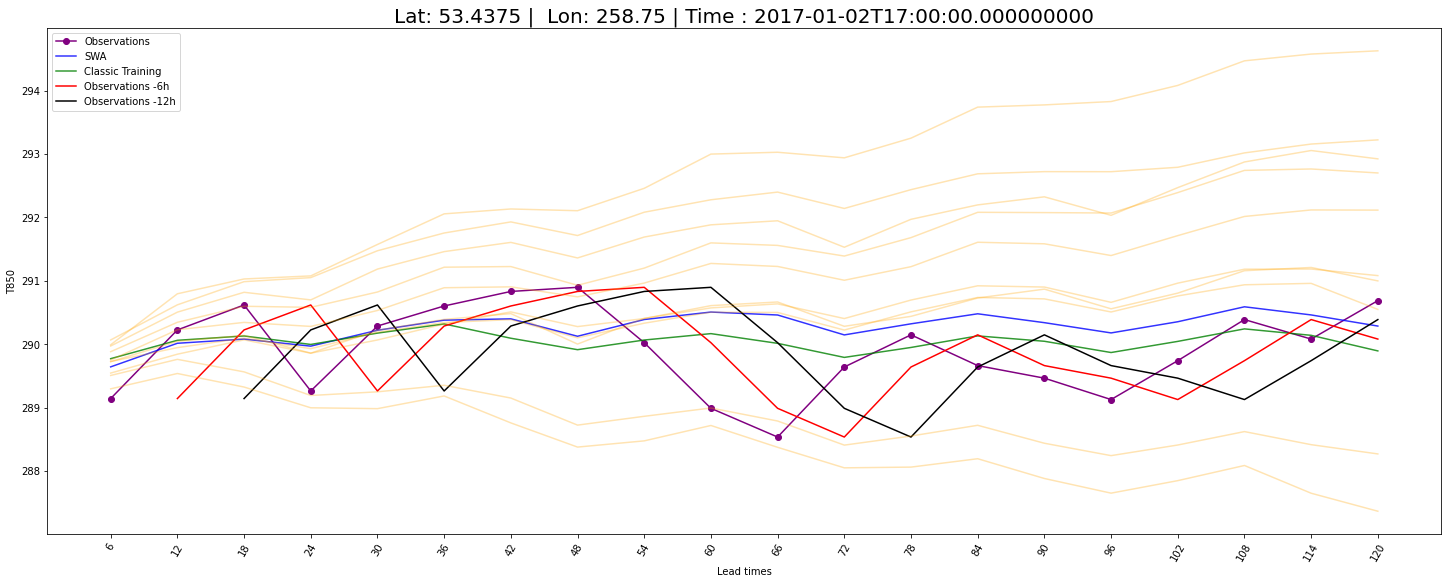

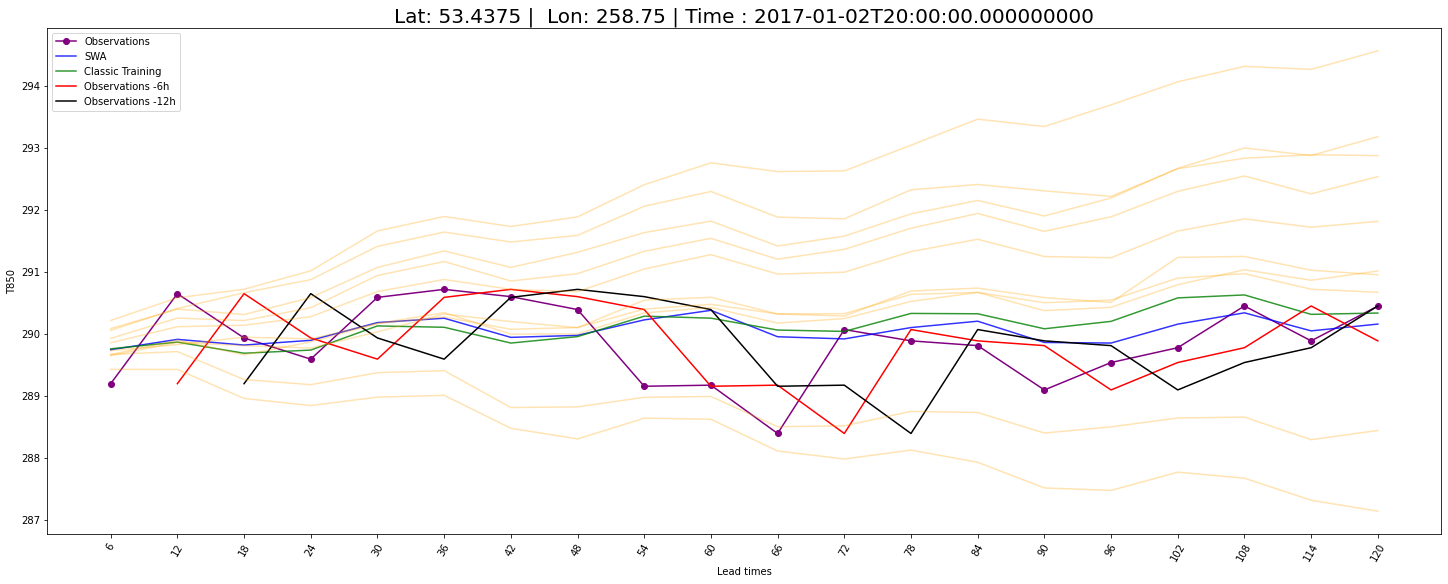

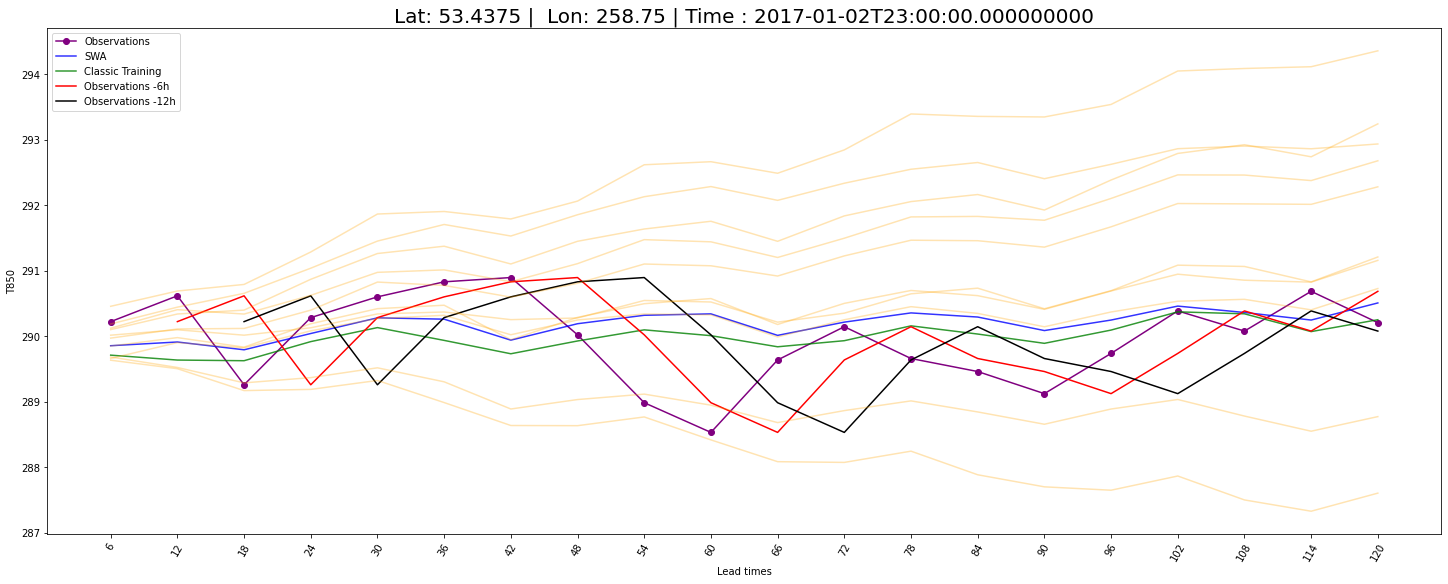

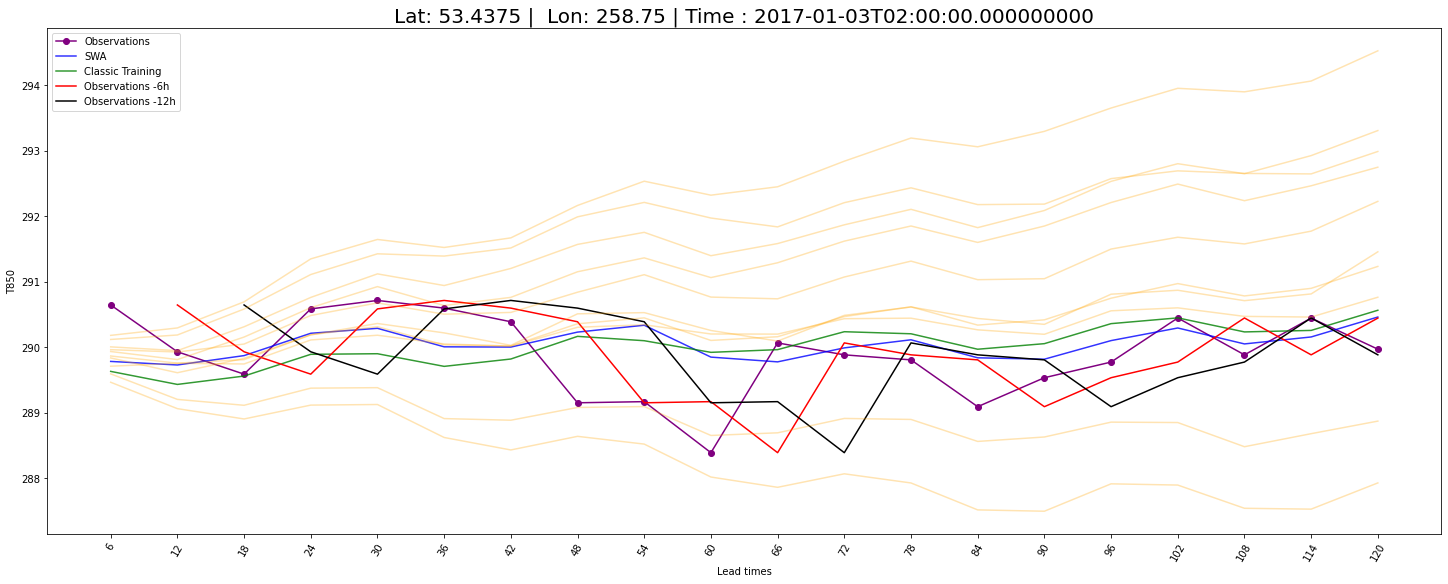

In [27]:
times = swa_equi_tropics.time.values
lead_times = swa_equi_tropics.lead_time.values

for time in times:
    # print("Lat:", lat, " | Lon:", lon)
    f, ax = plt.subplots(figsize=(20, 8), constrained_layout=True)
    
    realizations_to_plot_tropics = [r.sel(lat=pixel[0], lon=pixel[1], time=time) for r in realizations_equi_tropics]
    swa_to_plot_tropics = swa_equi_tropics.sel(lat=pixel[0], lon=pixel[1], time=time)
    classic_to_plot_tropics = classic_equi_tropics.sel(lat=pixel[0], lon=pixel[1], time=time)
    obs_to_plot_tropics = obs_equi_tropics.sel(lat=pixel[0], lon=pixel[1], time=time)
    shifted_obs_to_plot_tropics = shifted_obs_tropics.sel(lat=pixel[0], lon=pixel[1], time=time)
    shifted_obs_2_to_plot_tropics = shifted_obs_2_tropics.sel(lat=pixel[0], lon=pixel[1], time=time)
    
    ax.plot(lead_times, obs_to_plot_tropics.t.values, color='purple', marker='o', label='Observations')
    
    ax.plot(lead_times, swa_to_plot_tropics.t.values, color='blue', alpha=0.8, label='SWA')
    ax.plot(lead_times, classic_to_plot_tropics.t.values, color='green', alpha=0.8, label='Classic Training')
    
    ax.plot(lead_times, shifted_obs_to_plot_tropics.t.values, color='red', label='Observations -6h')
    ax.plot(lead_times, shifted_obs_2_to_plot_tropics.t.values, color='black', label='Observations -12h')
    
    for i, r in enumerate(realizations_to_plot_tropics):
        ax.plot(lead_times, r.t.values, color='orange', alpha=0.3)
        
    ax.set_xticks(lead_times)
    ax.set_xlabel('Lead times')
    ax.xaxis.set_tick_params(rotation=60) 
    ax.set_ylabel('T850')

    ax.legend()

    plt.title(f"Lat: {lat} |  Lon: {lon} | Time : {time}", fontsize=20, 
              horizontalalignment='center')

    plt.show()